### Implement the stacked autoencoder based deep neural network for the classification problem. The deep neural network must contain 3 hidden layers from three autoencoders. You can use holdout (70, 10, and 20%) cross-validation technique for selecting, training and test instances for the classifier. The dataset (data5.mat) contains 72 features and the last column is the output (class labels). For autoencoder implementation, please use back propagation algorithm which has been already taught in the class. Evaluate individual accuracy and overall accuracy. (Packages such as keras, tensorflow, pytorch for python and MATLAB deep learning toolbox etc. are not allowed)


In [ ]:
#import all the necessory libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from mpl_toolkits import mplot3d
import scipy.io

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
root="/content/drive/MyDrive/NNFL_Assignment2/data5.mat"
data=scipy.io.loadmat(os.path.join(root))
data=data['x']
print((data.shape))


(2148, 73)


In [ ]:
def onehoten(data):
    y=data[:,-1]
    count=0
    cls=[]
    for insts in range(0,y.shape[0]):
        if y[insts] in cls:
            continue
        else:
            cls.append(y[insts])
    nclasses=len(cls)
    z=np.zeros([y.shape[0],nclasses],dtype=int)
    for insts in range(0,y.shape[0]):
        z[insts,int(y[insts])]=z[insts,int(y[insts])]+1
    return z
        

In [ ]:
def split_classes(data):
    x=np.delete(data,-1,1)
    y=onehoten(data)
    c=[]
    for cls in range(0,y.shape[1]):
        temp=[]
        for insts in range(data.shape[0]):
            if y[insts,cls]==1:
                temp.append(data[insts])
        c.append(np.array(temp))
    return(c)

In [ ]:
def split_train_test(classes,trainperc):
    for c in range(len(classes)):
        dat=classes[c]
        train=dat[:round(dat.shape[0]*trainperc/100),:]
        test=dat[round(dat.shape[0]*trainperc/100):,:]
        if c!=0:
            train=np.concatenate((trainold,train),axis=0)
            test=np.concatenate((testold,test),axis=0)
        trainold=train
        testold=test
    np.random.shuffle(train)
    np.random.shuffle(test)
        
    return train , test

In [ ]:
def split_x_y(data):
    x=np.delete(data,-1,1)
    x=normalize(x).T
#   x=np.concatenate((x,np.ones((data.shape[0],1))),axis=1)
    y=onehoten(data).T
    # y=x
    return x,y

In [ ]:
def normalize(data):
    for i in range(data.shape[1]):
        temp=data[:,i]
        data[:,i]=(temp-np.mean(temp))/np.std(temp)
    return data

In [ ]:
#input list of ints(no.of perceptrons per layer).in this question, ist [72,50,50,2].
def init_par(l):
    w=[]
    b=[]
    for i in range(len(l)-1):
        we=np.random.rand(l[i],l[i+1])
        be=np.zeros((l[i+1],1))
        w.append(we)
        b.append(be)
    return (w),(b)
        
        

In [ ]:
def sigmoid(z):
    s=1/(1+np.exp(-z))
    return s

In [ ]:
def forward_prop(w,b,x_train):
    nlayers=len(w)+1
    lv=[]
    a=x_train
    lv.append(a)
    #l is the layer-1
    for l in range(0,nlayers-1):
        ai=a
        a=sigmoid(np.dot(w[l].T,ai)+b[l])
        lv.append(a)
    pred=lv[-1]
    return pred,lv

In [ ]:
def back_prop(w,b,lv,y_train,alpha,lamda):
    for l in reversed(range(0,len(lv))):
        if l==(len(lv)-1):
            dl=(-y_train+lv[l])*lv[l]*(1-lv[l])
        else:
            dl=np.dot(w[l],dn)*lv[l]*(1-lv[l])
            dw=np.dot(lv[l],dn.T)
            db=db=np.sum(dn,axis=1,keepdims=True)
            w[l]=((1-(alpha*lamda))*w[l])-(alpha*dw)
            b[l]=b[l]-(alpha*db)
        dn=dl
    return w,b

    


In [ ]:
def pretrain(l,x_train):
    w,b=init_par(l)
    h=x_train
    for l in range(len(l)-1):
        we=[w[l],w[l].T]
        be=[np.zeros((w[l].shape[1],1)),np.zeros((w[l].shape[0],1))]
        he=[h,h]
        for eps in range(0,10):
            p,lv=forward_prop(we,be,h)
            we,be=back_prop(we,be,lv,h,0.01,0.01)
        w[l]=we[0]
        b[l]=be[0]
        h=sigmoid(np.dot(w[l].T,h)+b[l])
    return w,b




In [ ]:
def accur(pred,y):
    count=0
    for inst in range(y.shape[1]):
        if np.argmax(pred.T[inst])==np.argmax(y.T[inst]):
            count=count+1
    acc=count/y.shape[1]
    return acc

In [ ]:
def MLP(data,epochs,alpha,lamda,percepset=[72,50,25,10,2]):
    train,test=split_train_test(split_classes(data),80)
    train,valid=split_train_test(split_classes(train),87.5)
    x_train,y_train=split_x_y(train)
    x_valid,y_valid=split_x_y(valid)
    x_test,y_test=split_x_y(test)
    w,b=pretrain(percepset,x_train)
    # w,b=init_par(percepset)
    es=[]
    ev=[]

    for eps in range(0,epochs):
        pred,lv=forward_prop(w,b,x_train)
        predval,_=forward_prop(w,b,x_valid)
        e=sum(sum((y_train-pred)**2))/y_train.shape[1]/y_train.shape[0]
        evalid=sum(sum((y_valid-predval)**2))/y_valid.shape[1]/y_valid.shape[0]
        w,b=back_prop(w,b,lv,y_train,alpha,lamda)
        es.append(e)
        ev.append(evalid)
    predtest,_=forward_prop(w,b,x_test)
    testerror=sum(sum((y_test-predtest)**2))/y_test.shape[1]/y_test.shape[0]
    print("Test error={}".format(testerror))
    acc=[accur(pred,y_train),accur(predval,y_valid)]

    h_test=np.rint(predtest[0,:]).reshape((test.shape[0],1))
    y_test=y_test[0,:].reshape((test.shape[0],1))
    error = (y_test-np.rint(h_test)).tolist()
    som = (y_test+np.rint(h_test)).tolist()
    FN = error.count([1.0])
    FP = error.count([-1.0])
    TN = som.count([0.0])
    TP = som.count([2.0])
    accuracy = (TP+TN)/(TP+TN+FP+FN)
    sensitivity = TP/(TP+FN)
    specificity = TN/(FP+TN)
    conf_matrix = np.array(([TP,FP],[FN,TN]))

    return es,ev,testerror,acc,accuracy,sensitivity,specificity,conf_matrix

In [ ]:
train_error,validation_error,test_error,accuracy,accs,sens,specs,confmats=MLP(data,3000,0.008,0.01)

Test error=0.08055459755409089


In [ ]:
print("Train error converged from {} to {}".format(train_error[0],train_error[-1]))
print("Validation error converged from {} to {}".format(validation_error[0],validation_error[-1]))
print("Training accuracy and Testing accuracy are {} respectively".format(accuracy))
print("Accuracy={}".format(accs))
print("Sensitivity={}".format(sens))
print("Specificity={}".format(specs))
print(confmats)

Train error converged from 0.47028799115096465 to 0.01138991116876878
Validation error converged from 0.4696306737716704 to 0.07884129190139882
Training accuracy and Testing accuracy are [0.9886892880904857, 0.9069767441860465] respectively
Accuracy=0.9069767441860465
Sensitivity=0.9023255813953488
Specificity=0.9116279069767442
[[194  19]
 [ 21 196]]


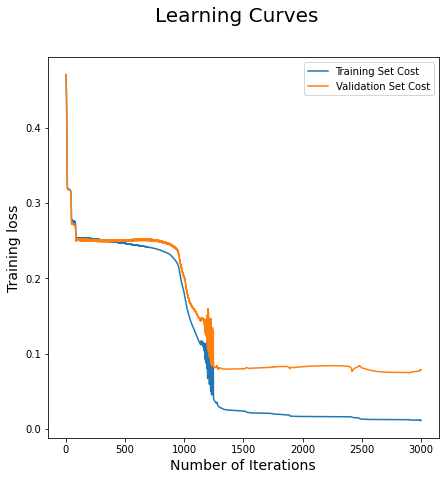

In [ ]:
fig=plt.figure()
fig.set_figheight(7)
fig.set_figwidth(7)
fig.suptitle('Learning Curves', fontsize=20)
plt.xlabel('Number of Iterations', fontsize=14)
plt.ylabel('Training loss',fontsize=14)
plt.plot(range(0,len(train_error)),train_error, label = 'Training Set Cost')
plt.plot(range(0,len(validation_error)),validation_error, label = 'Validation Set Cost')
plt.legend()
plt.show()